# Greenland: convert drainage systems (boundaries) to polygon shapefile

## General context
This serie of notebooks presents the results of preliminary activities to a scientific study to be conducted for CNES (French spatial agency)
with the collaboration of Météo France.<br> 
The study is focusing on the observation of Greenland using specific instruments (microwave radiometers) on-board satellite missions.<br>
The preliminary activities consist on preparation of data handling and data representation.<br>



## References

- Mass changes over greenland<br>
Barletta, V. R., Sørensen, L. S., and Forsberg, R.: Scatter of mass changes estimates at basin scale for Greenland and Antarctica, The Cryosphere, 7, 1411–1432, https://doi.org/10.5194/tc-7-1411-2013, 2013. 

- Drainage systems<br>

    o main reference:<br> 
    Zwally, H. J., Jun LI, Anita C. Brenner, Matthew Beckley, Helen G. Cornejo, John DiMarzio,<br> 
    Mario B. Giovinetto, Thomas A. Neumann, John Robbins, Jack L. Saba, Donghui Yi, Weili Wang, 2011,<br> 
    “Greenland ice sheet mass balance: distribution of increased mass loss with climate warming; 200307 versus 19922002,”<br> 
    Journal of Glaciology, Vol. 57, No. 201, pp 88-102, 2011.<br>
    
    o explanations: https://earth.gsfc.nasa.gov/cryo/data/polar-altimetry/antarctic-and-greenland-drainage-systems
    
    o download: https://earth.gsfc.nasa.gov/sites/default/files/lab_cryo/data/polar_ice_altimetry/antarctic_and_greenland_drainage_systems/grndrainagesystems_ekholm.txt
    
- Colorcet categorical colormap: https://colorcet.holoviz.org/user_guide/Categorical.html
    


## Objective of the notebook
The monitoring of the impact of the climate change on the Greenland globally shows a decrease of the ice thickness.<br>
(source: polar portal http://polarportal.dk/en/greenland/mass-and-height-change/)

![mass loss global](http://polarportal.dk/fileadmin/polarportal/mass/Grace_combine_Sm_EN_20210800.png)

But, splitting the mass loss monitoring per drainage systems (as defined in Zwally et al. 2011) shows a large discrepency between the regions.

![mass loss per region](http://polarportal.dk/fileadmin/polarportal/mass/combined_EN.png)

so it would make sense to be able to split the future observations per drainage regions.<br>
The thing is, the initial data (text file, see above) defines the limit of the regions but cannot be used directly to mask, let's say, an xarray dataset. 

This notebook describe how to convert the limit of the drainage systems into shapefile polygons. (The next notebook focuses on applying the polygon shapefile mask to an xarray) 

## The script

The approach is based on:<br>
- shapefile to define the polygons from the longitudes and latitudes of the boundaries
- geopandas to apply the crs and dump the shapefile

The map is generated as in the previous notenook. To lighten the code, the initialisation step of the figure are gathered in the lib_cartopy library

In [1]:
import numpy as np
import xarray as xr

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import colorcet as cc

from cartopy.io.shapereader import Reader as creader
from cartopy import crs as ccrs

import matplotlib.pyplot as plt

import lib_cartopy as lc

Let's convert the txt file in netcdf file. Note the shift applied on the longitude.

In [2]:
buf = np.loadtxt('files/grndrainagesystems_ekholm.txt',skiprows=7)
ds = xr.Dataset({'grndrainagesystems':(['ncells'],buf[:,0])},
                    coords={'latitude':('ncells',buf[:,1]),'longitude':('ncells',buf[:,2]),'ncells':('ncells',range(buf[:,0].size))})
ds.to_netcdf('files/grndrainagesystems_ekholm.nc','w')
ds = xr.open_dataset('files/grndrainagesystems_ekholm.nc')
lon = ds.longitude.values
lon[lon>180] = lon[lon>180]-360  
minlon,maxlon = ds.longitude.min(),ds.longitude.max()
minlat,maxlat = ds.latitude.min(), ds.latitude.max()
da = ds['grndrainagesystems']

Now for the conversion of the limits of the boundaries as polygons.<br>
This is performed by looping over the different regions defined by a single identifier.<br>
Then the list of polygons is convert into a shapely multipolygon.<br>
Finally, the multipolygon is converted in a geopandas dataframe and dump as a shapefile.<br>

In [3]:
# unique values of the region identifier
list_of_regions = list(np.unique(da.values))
# init list of polygons for each reagions
list_of_polygons = []
# loop regions
for regval in list_of_regions:
    daf = da.where(da==regval,drop=True)
    lon_point_list = daf.longitude.values
    lat_point_list = daf.latitude.values
    list_of_polygons.append(Polygon(zip(lon_point_list , lat_point_list)))
polygons = shapely.geometry.MultiPolygon(list_of_polygons)
# dump to shapefile
# WGS 84 / NSIDC Sea Ice Polar Stereographic North
crs = 'epsg:3413'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygons])     
shpfilename = 'files/grndrainagesystems_ekholm.shp'  
polygon.to_file(filename=shpfilename, driver="ESRI Shapefile")

/home/bpicard/anaconda3/envs/geopandas/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Each region is added separatly and associated to a color defined by the glasbey_cool colormap loaded from colorcet library

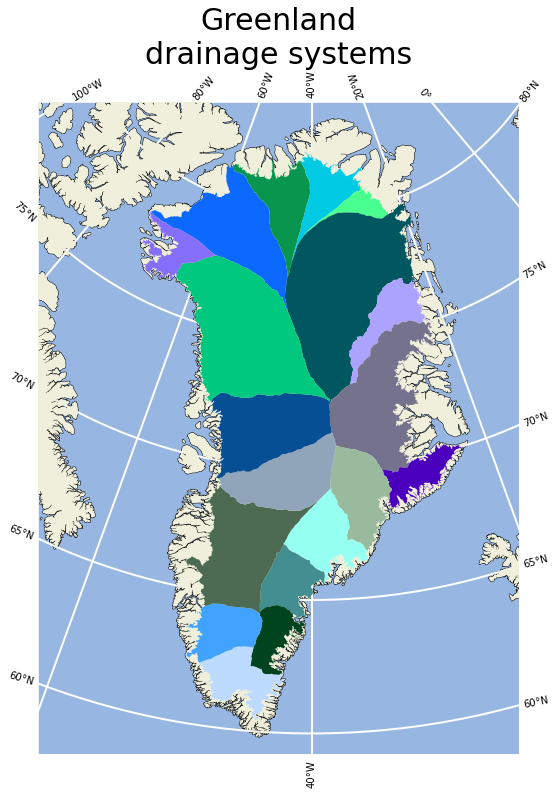

In [4]:
# resolution of coastlines and features
resolution = '10m'
# colormap
colors=cc.glasbey_cool
# init map
fig,ax = lc.init_map(title='Greenland\ndrainage systems',resolution=resolution)
# read and add regions
shp = creader(shpfilename)
multipolygon = list(shp.records())[0]
list_of_polygons = list(multipolygon.geometry.geoms)
for ip,poly in enumerate(list_of_polygons):
    ax.add_geometries([poly],ccrs.PlateCarree(),facecolor=colors[ip],zorder=4)